<a href="https://colab.research.google.com/github/aliakbarbadri/mountain-car-v0/blob/master/double_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the packages and Show the video

In [1]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install pyglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 2s (258 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The 

In [2]:
import matplotlib.animation
from IPython.display import HTML
from IPython.display import display as ipy_disp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gym
import random

In [3]:
# %matplotlib inline

def get_screen():
  global display
  try:
    display.stop()
  except:
    pass
  from pyvirtualdisplay import Display
  display = Display(visible=0, size=(1400, 900))
  display.start()

get_screen()

In [5]:
import os

# Where to save the figures
PROJECT_ROOT_DIR = "."
HW_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", HW_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

In [7]:
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# Setup the Env

In [15]:
env = gym.make('MountainCar-v0')

In [16]:
env.seed(42)
obs = env.reset()
obs
# obs = array([position, velocity])
# position = [-1.2 , 0.6]
# velocity = [-0.07,	0.07]

array([-0.52517132,  0.        ])

In [17]:
env.action_space
# 0	push left
# 1	no push
# 2	push right

Discrete(3)

In [18]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

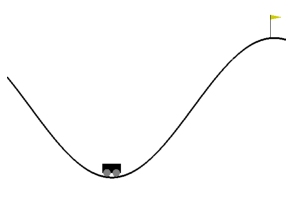

In [19]:
plot_environment(env)
plt.show()

In [20]:
action = 0
obs, reward, done, info = env.step(action)
obs, reward, done, info

(array([-0.52615953, -0.00098821]), -1.0, False, {})

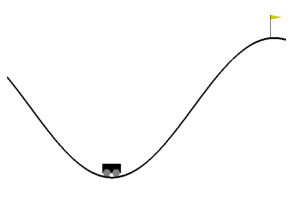

In [21]:
plot_environment(env)
plt.show()

# Random Actions

In [22]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        break

In [23]:
plot_animation(frames)

In [24]:
env.close()

# Double DQN

In [27]:
env.observation_space.shape[0], env.action_space.n

(2, 3)

In [39]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
input_shape = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation="relu", input_shape=[input_shape],kernel_initializer="he_uniform"),
    tf.keras.layers.Dense(16, activation="relu",kernel_initializer="he_uniform"),
    tf.keras.layers.Dense(n_outputs,kernel_initializer="he_uniform")
])

target = tf.keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [29]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [30]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [31]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [33]:
batch_size = 32
discount_rate = 0.95
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
loss_fn = tf.keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [34]:
from collections import deque

replay_memory = deque(maxlen=2000)

In [ ]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(1000):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if rewards[-1]+1<200:
      print("reward",rewards[-1]+1)
    if episode > 50:
        training_step(batch_size)
    if episode % 50 == 0:
        target.set_weights(model.get_weights())
    # Alternatively, you can do soft updates at each step:
    #if episode > 50:
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index in range(len(target_weights)):
        #    target_weights[index] = 0.99 * target_weights[index] + 0.01 * online_weights[index]
        #target.set_weights(target_weights)

model.set_weights(best_weights)

Saving figure double_dqn_rewards_plot


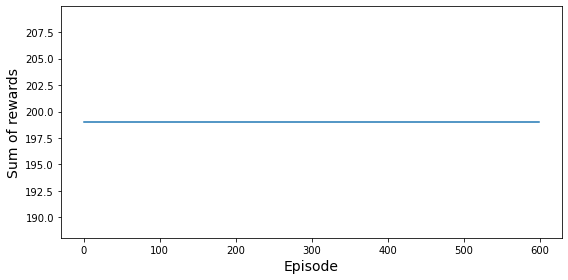

In [36]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("double_dqn_rewards_plot")
plt.show()

In [37]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)
env.close()

In [38]:
plot_animation(frames)